# Project 2 - Moneyball

## The Question

We want to understand how efficient teams have been historically at spending money and getting wins in return. In the case of Moneyball, one would expect that Oakland was not much more efficient than other teams in their spending before 2000, were much more efficient (they made a movie about it after all) between 2000 and 2005, and by then other teams may have caught up. Your job in this project is to see how this is reflected in the data we have.

## Part 1: Wrangling

The data you need to answer these questions is in the Salaries and Teams tables of the database.

#### Problem 1

**Using an SQL query only** compute a relation containing the total payroll and winning percentage (number of wins / number of games * 100) for each team (that is, for each teamID and yearID combination). You should include other columns that will help when performing EDA later on (e.g., franchise ids, number of wins, number of games).

**Hint:** Take a good look at the [SQLite Documentation](https://www.sqlitetutorial.net/).

Include as a cell the SQL code you used to create this relation. As a markdown cell, describe how you dealt with any missing data in these two relations. Specifically, indicate if there is missing data in either table, and how the type of join you used determines how you dealt with this missing data. 

**You must display the head of the resulting data table in your notebook.  You should also display the results of one team over the time range to make sure your data is correct.**

**Hint:** For SQL you have to be mindful of integer vs. float division.  See the above tutorial on how to deal with this.

In [205]:
# Import Statements
import sqlite3
import pandas as pd


In [206]:

sql2014_file = './baseball-archive-sqlite-master/lahman2014.sqlite'
conn = sqlite3.connect(sql2014_file)

# add columns to this query as needed for the subsequent EDA
my_query = """
SELECT * FROM

(SELECT yearID || teamID AS a_team_year, yearID, teamID, W, G, CAST(W AS float)/CAST(G AS float)*100 
AS 'WinPercentage'
FROM Teams) a
INNER JOIN
(SELECT SUM(salary) as total_payroll, yearID || teamID as b_team_year, COUNT(playerID) AS num_players
FROM Salaries
GROUP BY b_team_year) b

ON a.a_team_year = b.b_team_year
"""

payroll_winpercent = pd.read_sql(my_query, conn)
desired_columns = ["a_team_year", "teamID","yearID", "W", "G", "WinPercentage", "total_payroll", "num_players"]

payroll_winpercent
pw_df = payroll_winpercent[desired_columns]
pw_df.set_index("a_team_year")

pw_df.head()

,a_team_year,teamID,yearID,W,G,WinPercentage,total_payroll,num_players
0,1985BAL,BAL,1985,83,161,51.552795,11560712.0,22
1,1985BOS,BOS,1985,81,163,49.693252,10897560.0,25
2,1985CAL,CAL,1985,90,162,55.555556,14427894.0,28
3,1985CHA,CHA,1985,85,163,52.147239,9846178.0,21
4,1985CLE,CLE,1985,60,162,37.037037,6551666.0,20


## Part 2: Exploratory Data Analysis
## Payroll Distribution
### Problem 2
Write code to produce a plot that illustrate the distribution of payrolls across teams conditioned on time (from 1990-2014). This plot should be clear and interpretable.



In [207]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

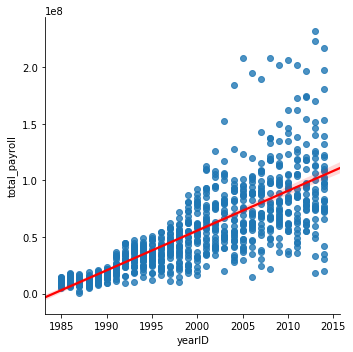

In [208]:
# Illustrate the distribution of payrolls across teams over time with a linear regression line.

sns.lmplot(x='yearID',y='total_payroll', data=pw_df,fit_reg=True, line_kws={'color': 'red'})

Write code to produce a scatter plot that shows winning percentage as a function of total payroll. That is, the total payroll on the x-axis and win percentage is on the y axis.

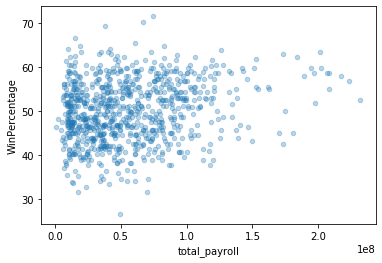

In [209]:
# Produces a scatter plot of total payroll vs win percentage
pw_df.plot.scatter(x = "total_payroll", y = "WinPercentage", alpha=0.3)

### Question 1
What statements can you make about the distribution of payrolls conditioned on time based on these plots? Remember you can make statements in terms of central tendency, spread, and other statistics discussed in class.

### Answer
From these plots, we can tell that there is a strong positive correlation between the year and the total payroll. It is difficult to see because there are so many data points.

However, by drawing the linear regression line, we can see that there is indeed a positive correlation. We can reinforce this statement by calculating the Pearson Correlation Coefficient below. Since the the coefficient is 0.75 we can say that the correlation between year and payroll is very strong. This makes sense because of inflation and a growing baseball market.

In [210]:
# Calculate correlation coefficient between total payroll and year.
pw_df["total_payroll"].corr(pw_df["yearID"])

0.7549806915717787

### Problem 3
Write code to produce plots that specifically show at least one of the statements you made in Question 1. For example, if you make a statement that there is a trend for payrolls to decrease over time, make a plot of a statistic for central tendency (e.g., mean payroll) vs. time to show that specifically.

### Answer
My linear regression line shows that there is a positive correlation between total payroll and the year. Next, I will plot the mean payroll over time further this arguement.

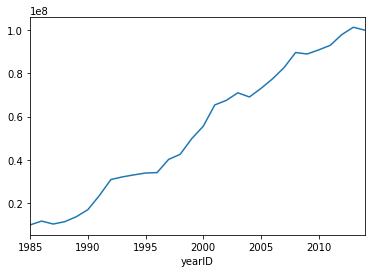

In [211]:
# Make a pairing with mean payroll for every year time.
payroll_vs_year = pw_df.groupby("yearID")["total_payroll"].mean()

payroll_vs_year.plot.line()

From this plot we can clearly see that the mean payroll increases over time.

## Correlation Between Payroll and Winning Percentage
### Problem 4
Write code to discretize year into five time periods (you can use pandas.cut to accomplish this) and then make a set of scatter plot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods.

Add a regression line (using, e.g., SciPy linregress which we did in Lecture 2) in each of the 5 scatter plot to ease interpretation.

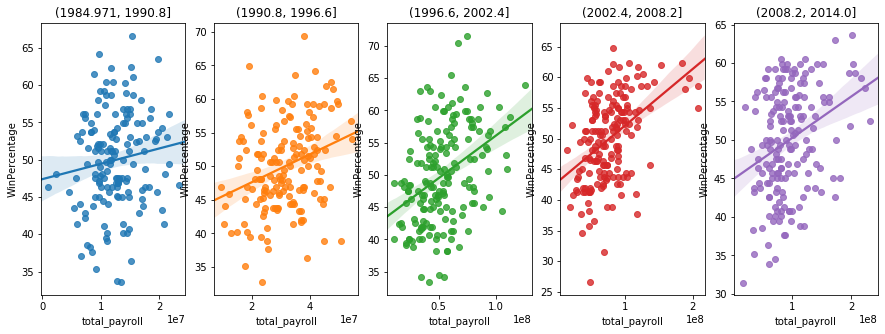

In [212]:
# Divide the data into 5 bins based on years.
pw_df["year_bin"] = pd.cut(pw_df["yearID"], bins = 5)

my_fig, my_ax = plt.subplots(1,5, figsize=(15,5))

year_bins = pw_df["year_bin"].unique()
    
for i, year_range in enumerate(year_bins):
    plot_year = pw_df[pw_df["year_bin"] == year_range]
    my_ax[i].set_title(year_range)
    sns.regplot(data = plot_year, x = "total_payroll", y = "WinPercentage", ax=my_ax[i])
#TODO: add lables to every point

### Question 2
What can you say about team payrolls across these periods? Are there any teams that standout as being particularly good at paying for wins across these time periods? What can you say about the Oakland A's spending efficiency across these time periods and specifically in the Moneyball period of 2000-2005.

### Answer
By looking at the above graphs I can tell there is a small positive correlation between the total payroll and the win percentage of the teams. The teams in the top left corner stand out as teams that had particularly good win rates given their payroll. During the period 2002-2008 the Oakland A's ______.

## Part 3: Data Transformations
### Standardizing Across Years
It looks like comparing payrolls across years is problematic so let's do a transformation that will help with these comparisons.

### Problem 5
Create a new variable in your dataset that standardizes payroll conditioned on year. For this we will compute the Z-score of the variables.

You must display the head of this DataFrame in your notebook to receive credit.

Hint: Recall our lab on filtering and transforming data! You may also want to check out the Transform function

In [213]:
average_pr_by_year = pw_df.groupby("yearID")["total_payroll"].mean()
std_pr_by_year = pw_df.groupby("yearID")["total_payroll"].std()

def average_payroll(year):
    return average_pr_by_year[year]

def standev_by_year(year):
    return std_pr_by_year[year]
    
pw_df["avg_payroll"] = pw_df["yearID"].apply(average_payroll)
pw_df["std_payroll"] = pw_df["yearID"].apply(standev_by_year)
pw_df["standardized_payroll"] = (pw_df["total_payroll"] - pw_df["avg_payroll"]) / pw_df["std_payroll"]

stan_df = pw_df[["a_team_year","teamID", "yearID","total_payroll",
               "standardized_payroll", "year_bin", "WinPercentage"]]
stan_df.head()

,a_team_year,teamID,yearID,total_payroll,standardized_payroll,year_bin,WinPercentage
0,1985BAL,BAL,1985,11560712.0,0.601068,"(1984.971, 1990.8]",51.552795
1,1985BOS,BOS,1985,10897560.0,0.332678,"(1984.971, 1990.8]",49.693252
2,1985CAL,CAL,1985,14427894.0,1.761474,"(1984.971, 1990.8]",55.555556
3,1985CHA,CHA,1985,9846178.0,-0.092838,"(1984.971, 1990.8]",52.147239
4,1985CLE,CLE,1985,6551666.0,-1.426192,"(1984.971, 1990.8]",37.037037


### Problem 6
Repeat the same plots as Problem 4, but use this new standardized payroll variable. Remember that you should have one plot for each of the 5 time periods.

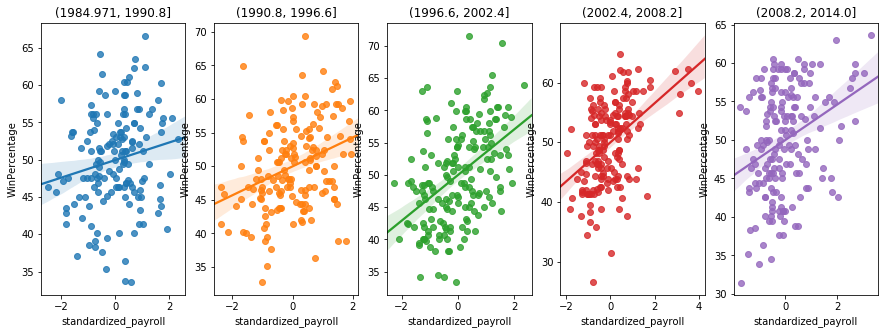

In [218]:
# Divide the data into 5 bins based on years.

stan_my_fig, stan_my_ax = plt.subplots(1,5, figsize=(15,5))

year_bins = stan_df["year_bin"].unique()
    
for i, year_range in enumerate(year_bins):
    plot_year = stan_df[stan_df["year_bin"] == year_range]
    stan_my_ax[i].set_title(year_range)
    sns.regplot(data = plot_year, x = "standardized_payroll", y = "WinPercentage", ax=stan_my_ax[i])

### Question 3
Discuss how the plots from Problem 4 and Problem 6 reflect the transformation you did on the payroll variable. Specifically, what is easier to see, what is harder to see? Are any relationships more apparent?

### Answer
The plots in Problem 6 are standardized whereas the plots in Problem 4 are not. In other words, the plots in Problem 6 reflect the position of different points in relation to other points in the graph. From here we can more easily see which points are average (in payroll), and which points are outliers (in payroll) by their position of the x-axis.

The graphs in Problem 4 are not standardized, so they are not helpful when thinking of team spending in relation to other teams. However, these graphs do allow us to see the actual amount each team spent, so they have a purpose.

## Expected Wins
It's hard to see global trends across time periods using these multiple plots, but now that we have standardized payrolls across time, we can look at a single plot showing correlation between winning percentage and payroll across time.

### Problem 7
Make a single scatter plot of winning percentage (y-axis) vs. standardized payroll (x-axis). Add a regression line to highlight the relationship. You do not need to label the teams in this plot.

The regression line gives you expected winning percentage as a function of standardized payroll. Looking at the regression line, it looks like teams that spend roughly the average payroll in a given year will win 50% of their games (i.e. win_pct is 50 when standardized_payroll is 0), and teams increase 5% wins for every 2 standard units of payroll (i.e., win_pct is 55 when standardized_payroll is 2). We will see how this is done in general using linear regression later in the course.

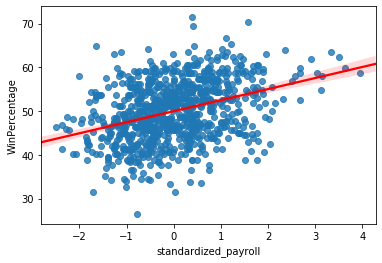

In [221]:
stan_df.head()
sns.regplot(data=stan_df, x = "standardized_payroll", y = "WinPercentage", line_kws={'color':'red'})

In [222]:
# Make column for expected win percentage
stan_df["expected_win_percent"] = 50 + (2.5 * stan_df["standardized_payroll"])
stan_df.head()

C:\Users\gw_va\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,a_team_year,teamID,yearID,total_payroll,standardized_payroll,year_bin,WinPercentage,expected_win_percent
0,1985BAL,BAL,1985,11560712.0,0.601068,"(1984.971, 1990.8]",51.552795,51.502671
1,1985BOS,BOS,1985,10897560.0,0.332678,"(1984.971, 1990.8]",49.693252,50.831694
2,1985CAL,CAL,1985,14427894.0,1.761474,"(1984.971, 1990.8]",55.555556,54.403684
3,1985CHA,CHA,1985,9846178.0,-0.092838,"(1984.971, 1990.8]",52.147239,49.767906
4,1985CLE,CLE,1985,6551666.0,-1.426192,"(1984.971, 1990.8]",37.037037,46.434521


## Spending Efficiency
Using this result, we can now create a single plot that makes it easier to compare teams efficiency. The idea is to create a new measurement unit for each team based on their winning percentage and their expected winning percentage that we can plot across time summarizing how efficient each team is in their spending.

### Problem 8
Create a new field to compute each team's spending efficiency.

In [226]:
# Make a column for each team's spending efficiency
stan_df["spending_efficiency"] = stan_df["WinPercentage"] - stan_df["expected_win_percent"]
stan_df.head()

C:\Users\gw_va\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,a_team_year,teamID,yearID,total_payroll,standardized_payroll,year_bin,WinPercentage,expected_win_percent,spending_efficiency
0,1985BAL,BAL,1985,11560712.0,0.601068,"(1984.971, 1990.8]",51.552795,51.502671,0.050124
1,1985BOS,BOS,1985,10897560.0,0.332678,"(1984.971, 1990.8]",49.693252,50.831694,-1.138442
2,1985CAL,CAL,1985,14427894.0,1.761474,"(1984.971, 1990.8]",55.555556,54.403684,1.151872
3,1985CHA,CHA,1985,9846178.0,-0.092838,"(1984.971, 1990.8]",52.147239,49.767906,2.379333
4,1985CLE,CLE,1985,6551666.0,-1.426192,"(1984.971, 1990.8]",37.037037,46.434521,-9.397484


Make a line plot with year on the x-axis and efficiency on the y-axis. A good set of teams to plot are Oakland, the New York Yankees, Boston, Atlanta and Tampa Bay (teamIDs OAK, BOS, NYA, ATL, TBA).

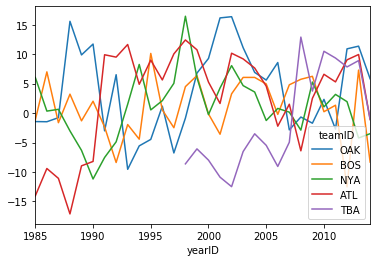

In [245]:
# stan_df.plot.line(x="yearID", y = "spending_efficiency")
eff_df = stan_df.pivot_table(index = "teamID", columns = ["yearID"], values = "spending_efficiency")
# eff_df.T.head()

desired_teams = ["OAK", "BOS", "NYA", "ATL", "TBA"]

eff_df.T[desired_teams].plot.line()

## Question 4
What can you learn from this plot compared to the set of plots you looked at in Question 2 and 3? How good was Oakland's efficiency during the Moneyball period?

## Answer
This plot allows us to view how a team"s spending efficiency changes over time. In the graphs that we analyzed in questions 2 and 3, we observed how different teams spent their money in relation to their win rate (within a certain interval). In the last graph, we do the same, except now we can see how that changes over time, since we are plotting spending efficiency over time.

This graph is really useful because it allows us to take a more in depth look at certain teams. We can also modify to code to compare any two teams we wish.

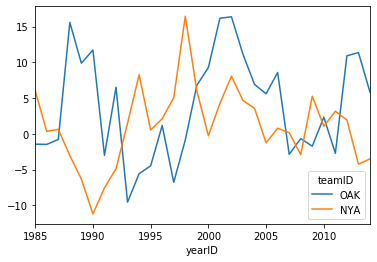

In [246]:
teams_to_compare = ["OAK", "NYA"]
eff_df.T[teams_to_compare].plot.line()


From this graph we can see that the spending efficiency of the Oakland As peaked during the Moneyball Period of 2000-2005. Around 2002-2003, Oakland had a spending efficienty that was +15. In other words, Oakland was doing phenominally for the amount of money they were spending.